Arthur Olga

Vitor Liu

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

# Projeto: Pedra-Papel-Tesoura

Neste projeto vocês devem construir um sistema que captura uma imagem da camera e diz se a imagem representa uma jogada de pedra, papel ou tesoura.

Projeto em duplas.

Entregável: Jupyter Notebook com a demonstração do sistema funcionando, e arquivo '.joblib' com o modelo treinado.

Entrega: 9/10, 23:59

Rubrica:

- I - Não entregou ou entregou nonsense.
- D - Funciona, mas com bugs menores.
- A - Funciona bem.

In [2]:
import os
import os.path
import re
from skimage.io import imread
from skimage.color import rgb2hsv

def transforma_imagem(img):
            # define range of blue color in HSV
        hsv= cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([30,20,100])
        upper_blue = np.array([80,255,255])

        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        return mask

In [3]:
def read_images():
    data_dir = os.path.join(os.getcwd(), 'newRPS')
    searcher = re.compile(r'^(.*)-(\d{1,2})\.jpg$')
    imgs = {}
    for name in os.listdir(data_dir):
        match = searcher.search(name)
        cat = match.group(1)
        num = int(match.group(2))
        img = imread(os.path.join(data_dir, name))
        
        img_and = transforma_imagem(img)
        
        '''
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        img_h = (img_hsv[:,:,0] >= 30) & (img_hsv[:,:,0] <= 80)
        img_s = (img_hsv[:,:,1] >= 20) & (img_hsv[:,:,1] <= 255)
        img_and = img_h & img_s
        '''
        
        if not cat in imgs:
            imgs[cat] = []
        imgs[cat].append(img_and)
    return imgs

imgs_per_cat = read_images()

paper: 25 images


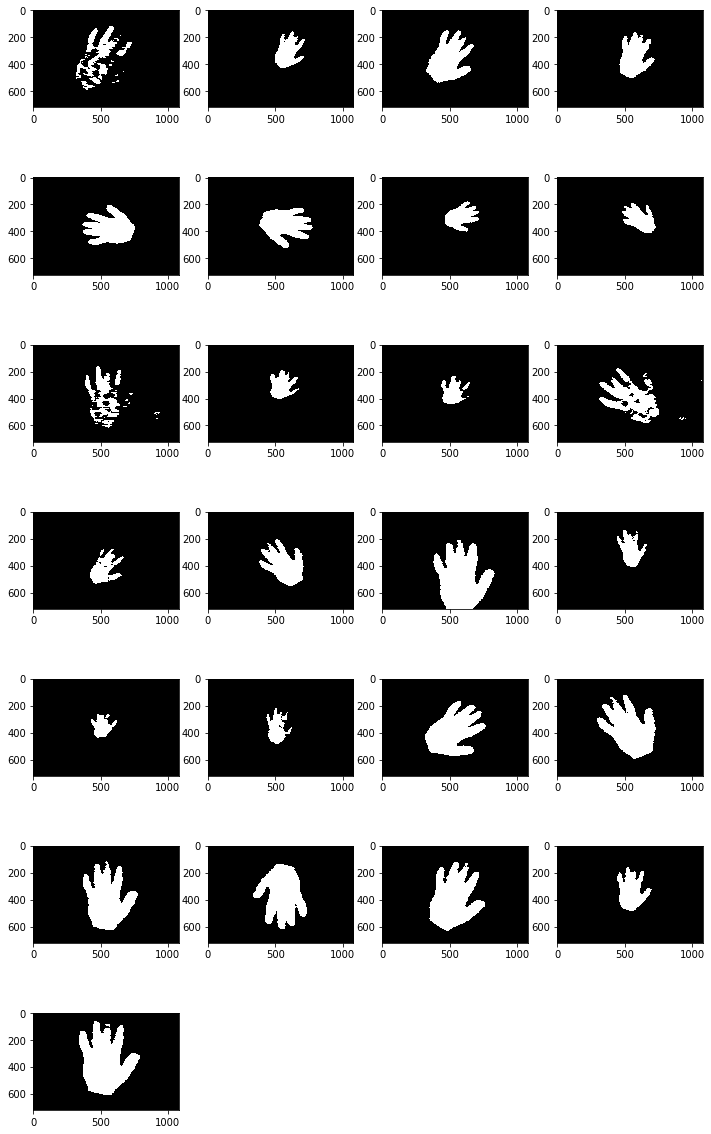

rock: 25 images


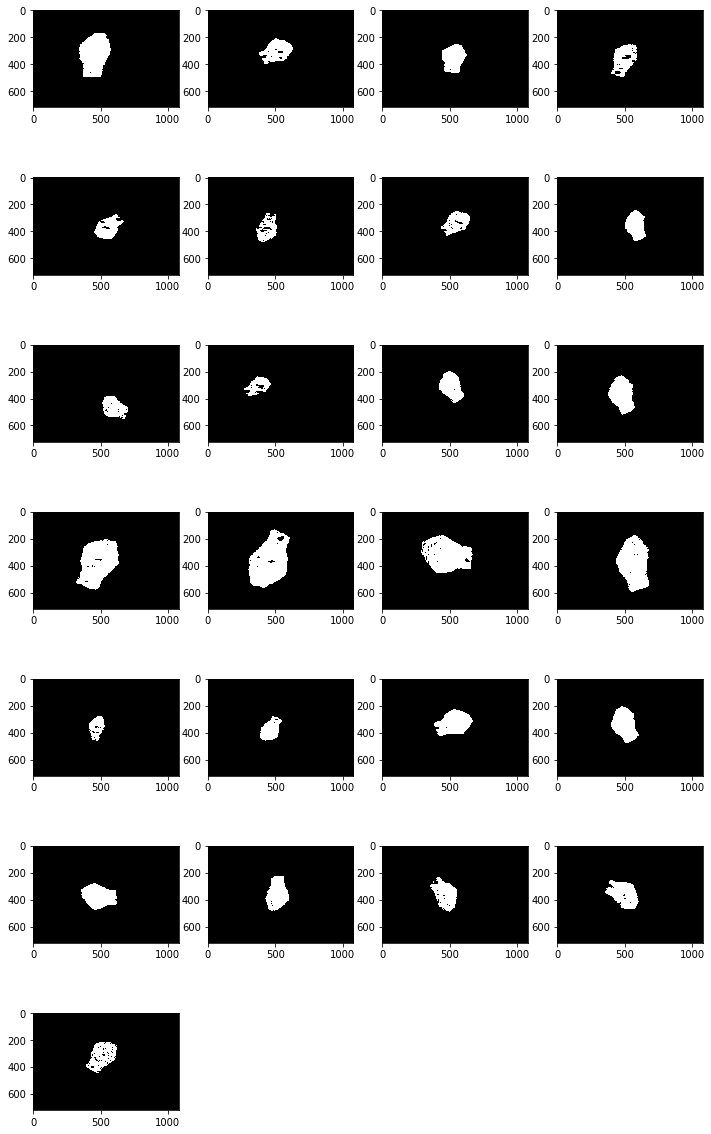

scissors: 25 images


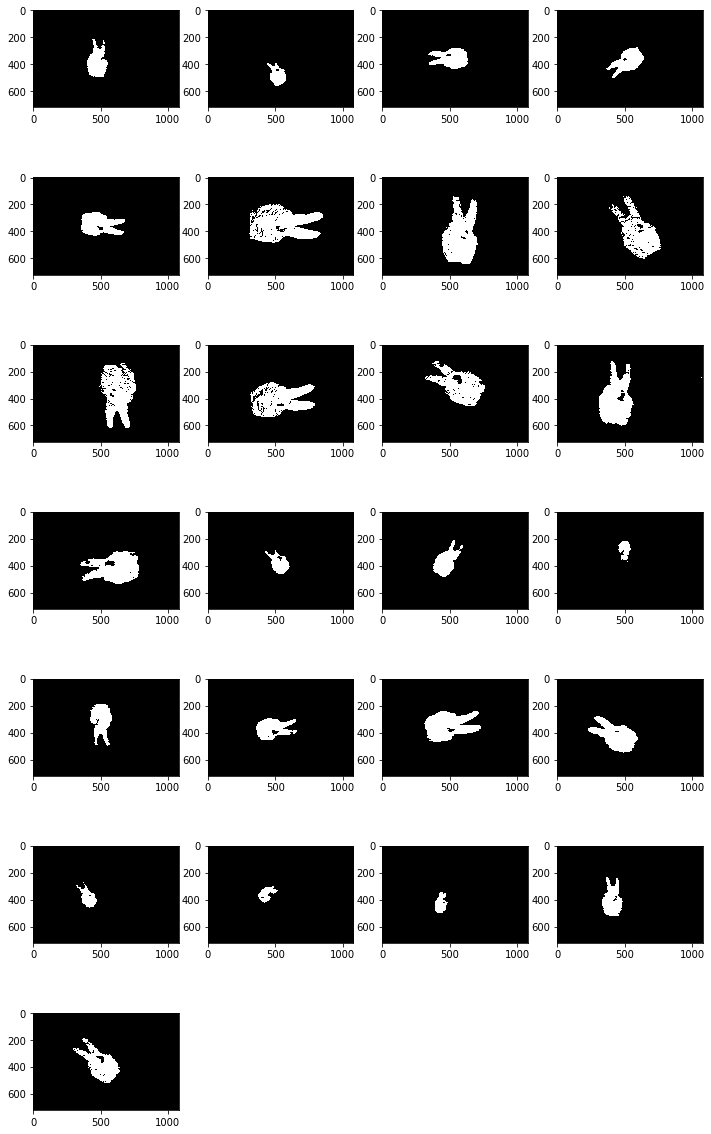

In [4]:
def show_images(imgs):
    C = 4
    N = len(imgs)
    R = (N - 1)//C + 1
    
    plt.figure(figsize=(C*3, R*3))
    for k, img in enumerate(imgs):
        plt.subplot(R, C, k+1)
        plt.imshow(img, cmap='gray')
    plt.show()

for cat, imgs in imgs_per_cat.items():
    print(f'{cat}: {len(imgs)} images')
    show_images(imgs)

In [5]:
from skimage.measure import regionprops, perimeter

X = []
y = []

for cat, imgs in imgs_per_cat.items():
    for img in imgs:
        props = regionprops(img.astype(int))[0]
        eccentricity = props['eccentricity']
        hu_moments = props['moments_hu']
        area = props['area']
        perimeter = props['perimeter']
        if perimeter == 0.0:
            perimeter = 1.0
        compactness = 4.0*np.pi*area/perimeter
        feats = [eccentricity, compactness] + list(hu_moments)
        X.append(feats)
        y.append(cat)

In [6]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



## RandomForestClassifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8947368421052632

In [8]:
# Salvando o modelo
import joblib

joblib.dump(clf, 'clf_model.joblib')

['clf_model.joblib']

In [9]:
# Lendo o modelo.
clf = joblib.load('clf_model.joblib')

Normalized confusion matrix
[[0.88 0.   0.12]
 [0.17 0.83 0.  ]
 [0.   0.   1.  ]]


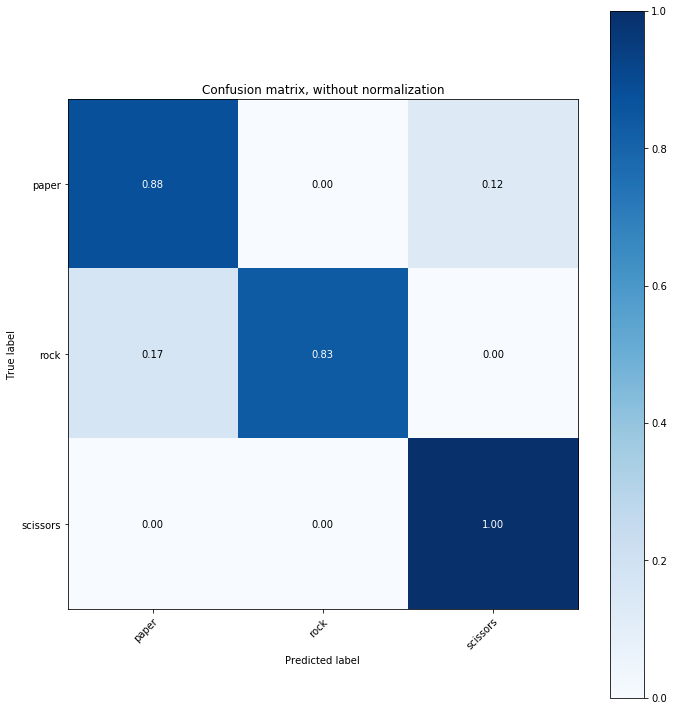

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## KNeighborsClassifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

knn = KNeighborsClassifier(n_neighbors = 8)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.21052631578947367

In [12]:
joblib.dump(knn, 'knn_model.joblib')

['knn_model.joblib']

In [13]:
# Lendo o modelo.
knn = joblib.load('knn_model.joblib')

Normalized confusion matrix
[[0.12 0.5  0.38]
 [0.17 0.   0.83]
 [0.2  0.2  0.6 ]]


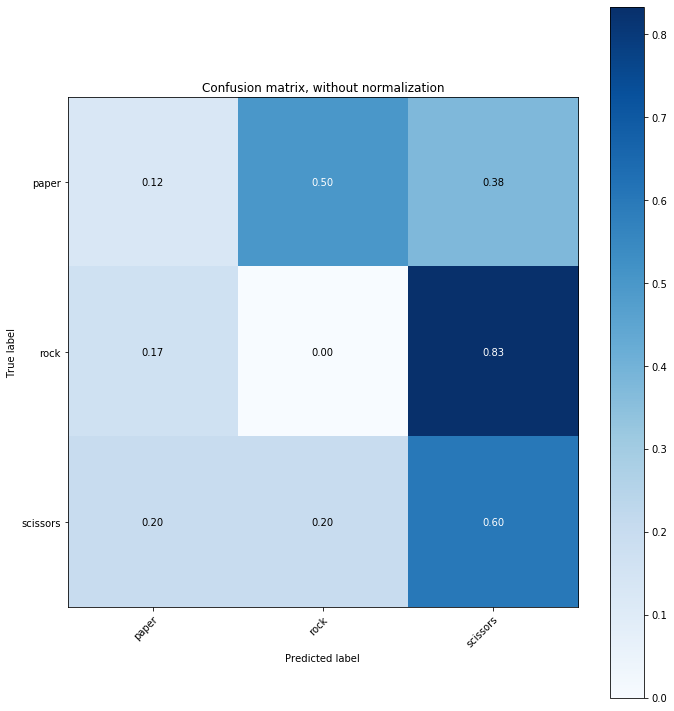

In [14]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=knn.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## GaussianNB

In [15]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nb = GaussianNB()

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

accuracy_score(y_test, y_pred)

0.6842105263157895

In [16]:
joblib.dump(nb, 'nb_model.joblib')

['nb_model.joblib']

In [17]:
# Lendo o modelo.
nb = joblib.load('nb_model.joblib')

Normalized confusion matrix
[[0.62 0.38 0.  ]
 [0.   0.67 0.33]
 [0.   0.2  0.8 ]]


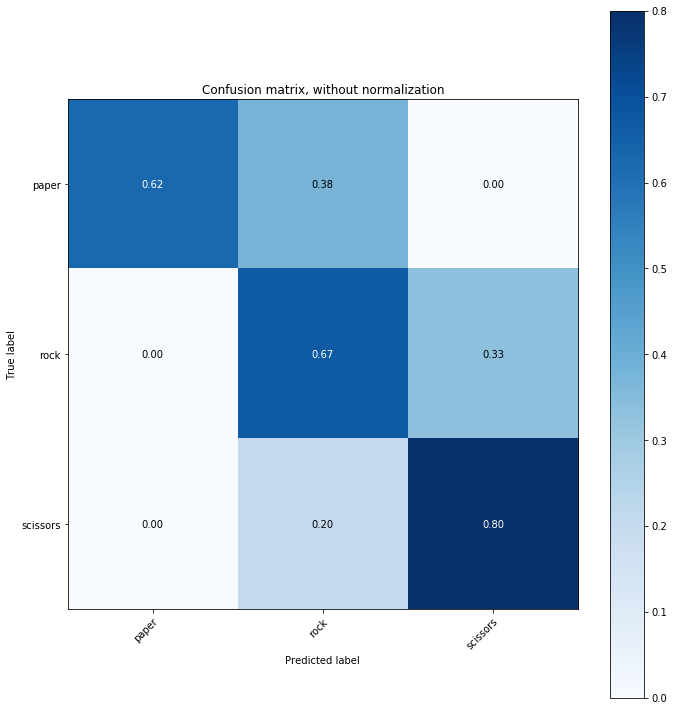

In [18]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=nb.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## MLPClassifier

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
xTrans = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(xTrans, y, test_size=0.25, random_state=42)

rede = MLPClassifier(hidden_layer_sizes=(100,100,100,100), activation="relu")

rede.fit(X_train, y_train)
y_pred = rede.predict(X_test)

accuracy_score(y_test, y_pred)

0.42105263157894735

In [20]:
joblib.dump(rede, 'MLP_model.joblib')

['MLP_model.joblib']

In [21]:
# Lendo o modelo.
rede = joblib.load('MLP_model.joblib')

Normalized confusion matrix
[[0.5  0.   0.5 ]
 [0.   0.17 0.83]
 [0.   0.4  0.6 ]]


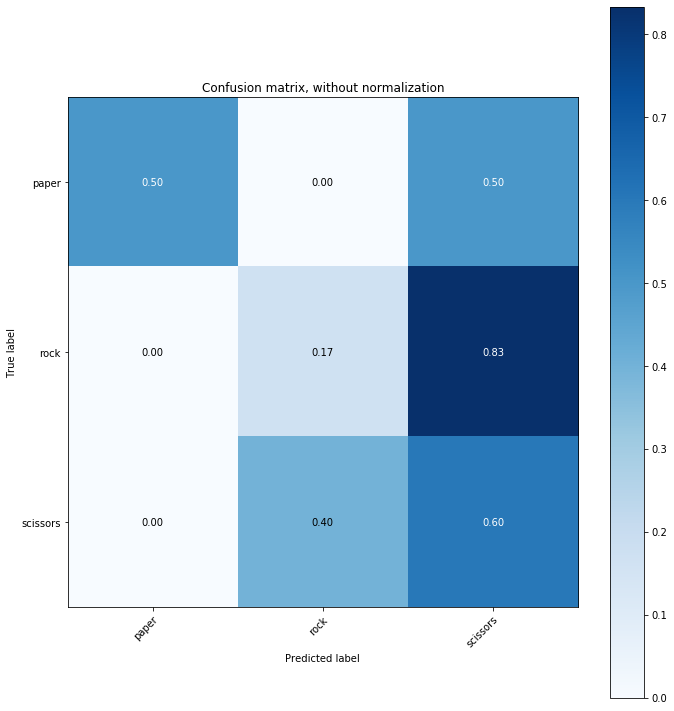

In [22]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=rede.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

## SVC

In [23]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

svc = GaussianNB()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy_score(y_test, y_pred)

0.6842105263157895

In [24]:
joblib.dump(rede, 'SVC_model.joblib')

['SVC_model.joblib']

In [25]:
svc = joblib.load('SVC_model.joblib')

Normalized confusion matrix
[[0.62 0.38 0.  ]
 [0.   0.67 0.33]
 [0.   0.2  0.8 ]]


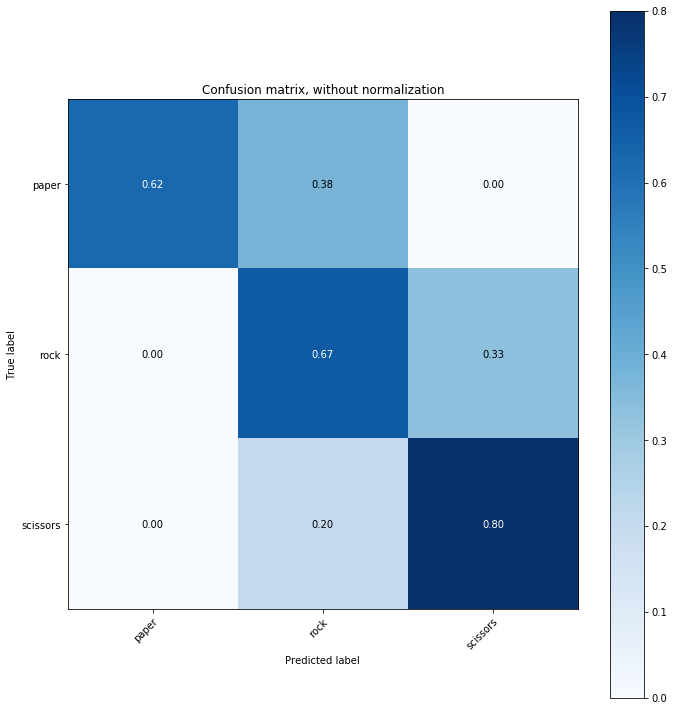

In [26]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=svc.classes_, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()

# Video

Usando o CLF

In [27]:
import os.path
from skimage.measure import regionprops, perimeter

def pega_features(img):
        props = regionprops(img.astype(int))[0]
        eccentricity = props['eccentricity']
        hu_moments = props['moments_hu']
        area = props['area']
        perimeter = props['perimeter']
        if perimeter == 0.0:
            perimeter = 1.0
        compactness = 4.0*np.pi*area/perimeter
        feats = [eccentricity, compactness] + list(hu_moments)
        return feats
snap = 0


font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 5
fontColor              = (0,255,0)
lineType               = 2

In [29]:
cap = cv2.VideoCapture(0)

_, frame = cap.read()
print(frame.shape)
while frame is not None:
    frame = frame[:, ::-1, :]
    
    frame_view = frame.copy()
    cv2.rectangle(frame_view, (220, 140), (420, 340), (0, 255, 0))

    frame_analise = transforma_imagem(frame_view)
    features = pega_features(frame_analise)
    # Gauss
    #y_pred = nb.predict([features])
    # Random Forest
    y_pred = clf.predict([features])
    #print(y_pred)
    cv2.putText(frame_view, y_pred[0], 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.imshow('frame', frame_view)
    cv2.imshow('frame_alaise', frame_analise)
    

    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        filename = f'snap_{snap:05d}.png' 
        cv2.imwrite(filename, frame)
        print(f'Saved {filename}')
        snap += 1

    _, frame = cap.read()

cap.release()
cv2.destroyAllWindows()

(480, 640, 3)
